In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,RandomForestRegressor

The shape of the image is :  (80, 80, 3) 

The image is :


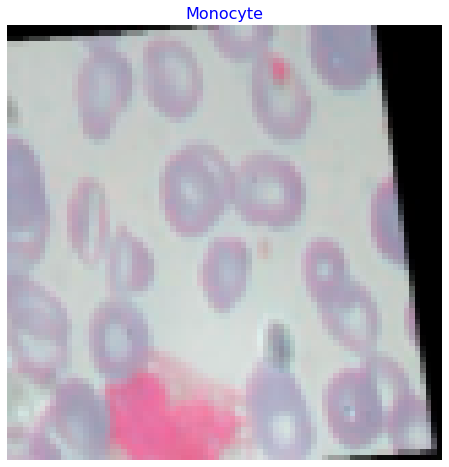

In [6]:
#Imports used for CNN
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from skimage import transform
from matplotlib import pyplot as plt
import cv2
import sys


#Reading the input image that will be taken for training
inp_image = transform.resize(cv2.imread(r"dataset2-master\images\TRAIN\MONOCYTE\_0_180.jpeg"), (80, 80, 3));

#Converting into an numpy array for further operations
inp_image = np.array(inp_image);

print("The shape of the image is : ", inp_image.shape , "\n")
print("The image is :")

fig = plt.subplots(1,figsize=(8,8));
plt.axis('off');
plt.title("Monocyte",fontsize = 16,color = 'blue');
plt.imshow(inp_image);

In [7]:
#Convolution operation head
def conv(img, convFilt):
    
    #To check if the number of image channels matches the filter depth.  
    if img.shape[-1] != convFilt.shape[1]:  
        print("Number of channels in both image and filter must match")  
        sys.exit()  
            
    if convFilt.shape[2] != convFilt.shape[3]:
        #To check whether the filer matrix is a square matrix 
        print('The Filter must be a square matrix. I.e. number of rows and columns should be the same')  
        sys.exit()  
        
    #To check if the filter matrix size is odd
    if convFilt.shape[2]%2==0: #Check if filter diemnsions are odd.  
        print('The Filter must have an odd size. I.e. number of rows and columns must be odd')  
        sys.exit() 
        
    #An empty matrix to store the output after convolution
    out_mat = np.zeros((img.shape[0]-convFilt.shape[2]+1,   
                        img.shape[1]-convFilt.shape[2]+1,   
                        convFilt.shape[0]))  
    
    #Convolving the image with each of the filter 
    for filterNum in range(convFilt.shape[0]):
        #print("Filter ", filterNum + 1)  
        
        #Choosing the filter from the available filters
        currentFilt = convFilt[filterNum, :]
        
        #If each filter has multiple channels
        if currentFilt.shape[0] > 2:
            
            #The initial convolution step
            convolutionMap = conv_(img[:, :, 0], currentFilt[0, :, :])
            
            #Convolving each channel with the image and summing the results.
            for ch in range(1, (currentFilt.shape[0])): 
                convolutionMap = convolutionMap + conv_(img[:, :, ch], currentFilt[ch, :, :]) 
                
        #If there is only one channel in the filter   
        else:
            convolutionMap = conv_(img, currentFilt)
        
        #Updating the output matrix at each step
        out_mat[:, :, filterNum] = convolutionMap
        
    return out_mat

In [8]:
#Main convolution operation
def conv_(img, convFilt):

    filtSize = convFilt.shape[0]  
    
    h = img.shape[0]-filtSize+1;
    w = img.shape[1]-filtSize+1;
    
    #Final result matrix that will store the values of convolved output
    result = np.zeros((h,w))  
    
    #Looping through the image to apply the convolution operation.  
    for r in np.uint16(np.arange(filtSize/2,   
                                 img.shape[0]-(filtSize/2)-2)):  
        for c in np.uint16(np.arange(filtSize/2, 
                                     img.shape[1]-filtSize/2-2)):
            
            #Taking the region from the image 
            currWindow = img[r:r+filtSize, c:c+filtSize]  
            
            #Convolution
            #Element-wise multiplication between the current region and the filter.
            #Using * because it is a dot product in python
            convResult = currWindow * convFilt  
            
            #Adding the result after multiplication
            finalSum = np.sum(convResult) 
            
            #Saving the final answer in the result matrix
            result[r, c] = finalSum
            
    #Removing the outliers from the result matrix
    final_result = result
    
    return final_result 

In [9]:
#Method to intialize a random filter with standard division as 1
def initializeFilter(size):
    #Using normal distribution to initialize a filter
    scale = 1
    stddev = scale/np.sqrt(np.prod(size))
    return np.random.normal(loc = 0, scale = stddev, size = size)

In [10]:
#Size of filters
#The first filter is of size 3x3x3 and the number of filters used is 10
#The second filter is of size 3x3x10 (Previous layer depth) and the number of filters used is 20
f1, f2 = (10,3,3,3), (20,10,3,3)

#Model to store each layer
model = [];

#Initializing random filters
f1 = initializeFilter(f1)
f2 = initializeFilter(f2)

print("Shape of the input image : ", inp_image.shape)

#Applying the first convolution step
fc = conv(inp_image,f1)
fc[fc<=0] = 0
print("Shape after applying first convolution : ",fc.shape)
model.append(fc);

#Applying the second convolution step
sc = conv(fc,f2)
sc[sc<=0] = 0
print("Shape after applying second convolution : ",sc.shape)
model.append(sc);

Shape of the input image :  (80, 80, 3)
Shape after applying first convolution :  (78, 78, 10)
Shape after applying second convolution :  (76, 76, 20)


The image that is being trained : 


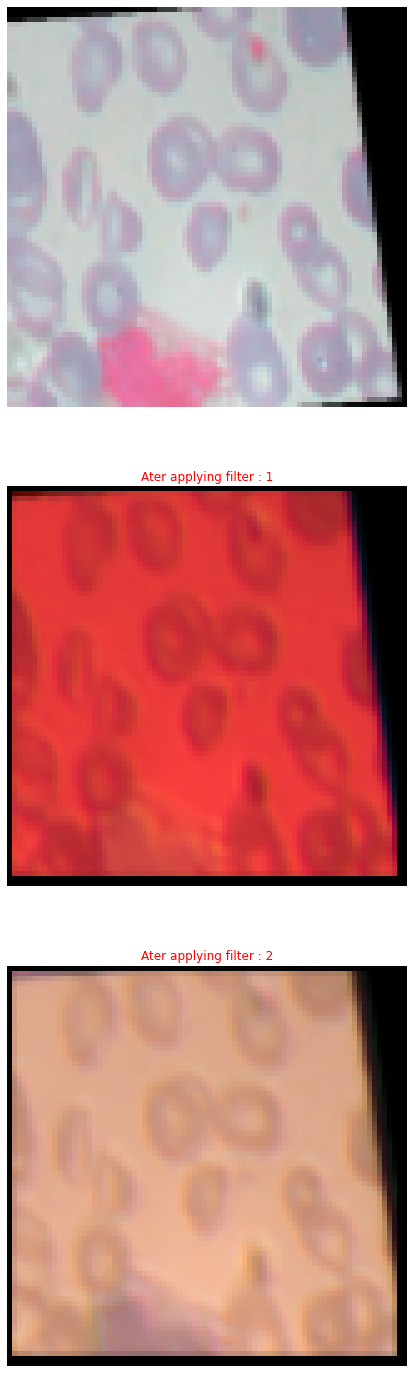

In [11]:
fig, axs = plt.subplots(len(model)+1,figsize=(25,25));
print("The image that is being trained : ")
axs[0].imshow(transform.resize(inp_image, (80, 80, 3)));
axs[0].axis('off')
count = 1;
for layer in model:
    layer = transform.resize(layer, (80, 80, 3));
    layer_norm = np.zeros((80,80,3));
    final_img = cv2.normalize(layer,layer_norm,0, 1, cv2.NORM_MINMAX);
    axs[count].axis('off');
    axs[count].set_title('Ater applying filter : ' + str(count) , color="red");
    axs[count].imshow(final_img);
    count = count + 1;

In [12]:
#Imports used for loading the data
import os
from tqdm import tqdm
import cv2
import numpy as np
np.set_printoptions(suppress=True)
from skimage import transform


def load_data(data):
    
    X_1 = []
    X_2 = []
    y_1 = []
    y_2 = []
    
    #To traverse every blood cell type folders in data 
    for bloodcell_type in os.listdir(data):
        if not bloodcell_type.startswith('.'):
        #In binary classification we have two classlabels 0 and 1 
        #If NEUTROPHIL and  EOSINOPHIL type cells found we just classify them as 1 and 
        #If MONOCYTE and  LYMPHOCYTE  type cells found we just classify them as 0 class label 
        
        #In multi class classification we will have 4 labels for respective classes.
            if bloodcell_type in ['NEUTROPHIL']:
                label_1 = 1
                label_2 = 0
            elif bloodcell_type in ['EOSINOPHIL']:
                label_1 = 1
                label_2 = 1
            elif bloodcell_type in ['MONOCYTE']:  
                label_1 = 0
                label_2 = 2
            elif bloodcell_type in ['LYMPHOCYTE']:
                label_1 = 0
                label_2 = 3
    
            #This loop is to traverse to every blood cell type in train data
            for filename in tqdm(os.listdir(data + '/' + bloodcell_type)):
                #To read every image in every folder
                image = cv2.imread(data +'/'+ bloodcell_type + '/' + filename)
                
                #If the image is found
                if image is not None:
                    #To resize the random sized images into a fixed size of 100x100x3
                    image = transform.resize(image, (80, 80, 3))
                    #Changing the datatype into array to process through the cnn algorithm
                    image_data_as_arr = np.asarray(image)
                    #Appending the data in the empty lists of X and y
                    X_1.append(image_data_as_arr)
                    X_2.append(image_data_as_arr)
                    y_1.append(label_1)
                    y_2.append(label_2)
    X_1 = np.asarray(X_1)
    y_1 = np.asarray(y_1)
    X_2 = np.asarray(X_2)
    y_2 = np.asarray(y_2)
    
    return X_1,X_2,y_1,y_2


#Loading the train and test data for both binary and multi class
X_train_bin, X_train_multi, y_train_bin, y_train_multi = load_data(r'dataset2-master/images/TRAIN/')
X_test_bin, X_test_multi, y_test_bin, y_test_multi = load_data(r'dataset2-master/images/TEST/')

100%|███████████████████████████████████████████████████████████████████████████████| 624/624 [00:03<00:00, 157.30it/s]


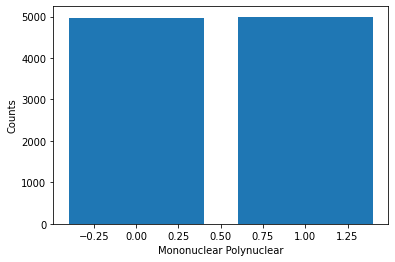

In [22]:
#To show the count of training data in each label
import pandas as pd
import matplotlib.pyplot as plt


df = pd.DataFrame()
df["labels"] = y_train_bin
counts = df['labels'].value_counts()
fig, ax = plt.subplots()
plt.bar(counts.index, counts.values)
ax.set_xlabel('Mononuclear Polynuclear')
ax.set_ylabel('Counts')
plt.show()

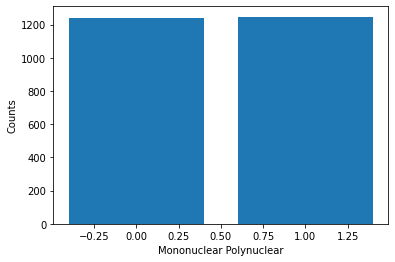

In [11]:
#To show the count of test data in each label

df = pd.DataFrame()
df["labels"] = y_test_bin
counts = df['labels'].value_counts()
fig, ax = plt.subplots()
plt.bar(counts.index, counts.values)
ax.set_xlabel('Mononuclear Polynuclear')
ax.set_ylabel('Counts')
plt.show()

In [17]:
#One hot encoding the output labels

from keras.utils.np_utils import to_categorical

#For training data
y_trainHot_bin = np.uint8(to_categorical(y_train_bin, num_classes = 2))

#For test data
y_testHot_bin = np.uint8(to_categorical(y_test_bin, num_classes = 2))

#For training data
y_trainHot_multi = np.uint8(to_categorical(y_train_multi, num_classes = 5))

#For test data
y_testHot_multi = np.uint8(to_categorical(y_test_multi, num_classes = 5))

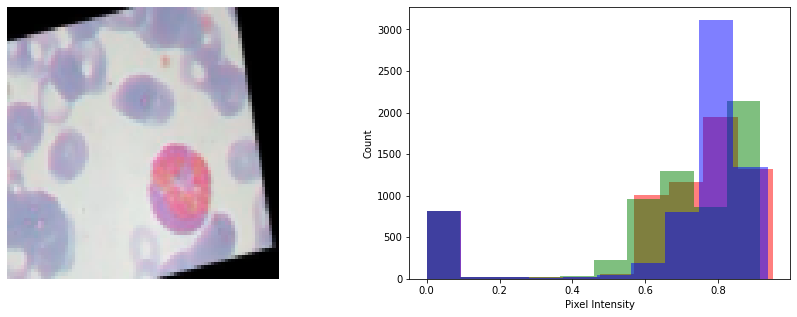

In [13]:
#To plot the intensity of each pixel of the image in the 3 different channels for red(r),green(g) and blue(b)
def plotHistogram(imag):
    
    #Figure size
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.imshow(imag)
    
    #Disable axis
    plt.axis('off')
    histog = plt.subplot(1,2,2)
    histog.set_ylabel('Count')
    histog.set_xlabel('Pixel Intensity')
    
    plt.hist(imag[:,:,0].flatten(), lw = 0, color='r', alpha=0.5);
    plt.hist(imag[:,:,1].flatten(), lw = 0, color='g', alpha=0.5);
    plt.hist(imag[:,:,2].flatten(), lw = 0, color='b', alpha=0.5);
    
plotHistogram(X_train_bin[1])

In [24]:
import seaborn as sn

def plot_confusion_matrix_bin(cm):

    #Setting the figure size
    fig, ax = plt.subplots(figsize=(10,5))
    
    #Creating the pandas dataframe
    d_cm = pd.DataFrame(cm)
    
    sn.set(font_scale=1)
    
    #Setting the fontsize and plotting the heatmap
    sn.heatmap(d_cm, annot=True, fmt='g',annot_kws={"size": 16})
    
    #Labels on the x and y axis
    plt.xticks([0.5,1.5],labels=["Mononuclear", "Polynuclear"])
    plt.yticks([0.2,1.2],labels=["Mononuclear", "Polynuclear"])
    plt.title('Confusion matrix')
    plt.xlabel('Actual label')
    plt.ylabel('Predicted label');

    plt.show()
    

def plot_confusion_matrix_multi(cm):

    #Setting the figure size
    fig, ax = plt.subplots(figsize=(12,5))
    
    #Creating the pandas dataframe
    d_cm = pd.DataFrame(cm)
    
    sn.set(font_scale=1)
    
    #Setting the fontsize and plotting the heatmap
    sn.heatmap(d_cm, annot=True, fmt='g',annot_kws={"size": 16})
    
    #Labels on the x and y axis
    plt.xticks([0.5,1.5,2.5,3.5],labels=["Neutrophil", "Eosinophil", "Monocyte", "Lymphocyte"])
    plt.yticks([0.2,1.2,2.2,3.2],labels=["Neutrophil", "Eosinophil", "Monocyte", "Lymphocyte"])
    plt.title('Confusion matrix')
    plt.xlabel('Actual label')
    plt.ylabel('Predicted label');

    plt.show()
    
def acc_versus_epochs(hist):
    
    plt.figure(figsize=(10,5))
    plt.subplot(2,1,2)
    loss_train = hist.history['accuracy']
    loss_val = hist.history['val_accuracy']
    epochs = range(1,21)
    plt.plot(epochs, loss_train, 'g', label='Training accuracy')
    plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.subplot(2,1,1)
    loss_train = hist.history['loss']
    loss_val = hist.history['val_loss']
    epochs = range(1,21)
    plt.plot(epochs, loss_train, 'g', label='Training Loss')
    plt.plot(epochs, loss_val, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [16]:
#The main CNN architecture
import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, MaxPool2D
from sklearn.metrics import classification_report, confusion_matrix

#The binary labels for our CNN model in the form of a dictionary
bin_labels = {0:'Mononuclear',1:'Polynuclear'}

def CNN(imgs,img_labels,test_imgs,test_labels,stride):
    
    #Number of classes (2)
    num_classes = len(img_labels[0])
    
    epochs = 20
    
    #Size of image
    img_rows,img_cols=imgs.shape[1],imgs.shape[2]
    input_shape = (img_rows, img_cols, 3)
    
    #Creating the model
    model = Sequential()
    
    #First convolution layer
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,
                     strides=stride))
    
    #First maxpooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #Second convolution layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    
    #Second maxpooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #Third convolution layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    
    #Third maxpooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #Convert the matrix to a fully connected layer
    model.add(Flatten())
    
    #Dense function to convert FCL to 128 values
    model.add(Dense(128, activation='relu'))
    
    #Dense function to convert FCL to 128 values
    model.add(Dense(64, activation='relu'))
    
    #Final dense layer on which softmax function is performed
    model.add(Dense(num_classes, activation='softmax'))
    
    #Model parameters
    model.compile(loss='categorical_crossentropy',
                  optimizer='adamax',
                  metrics=['accuracy'])
    
    #Evaluate the model on the test data before training your model
    score = model.evaluate(test_imgs,test_labels, verbose=1)
    
    print('\nKeras CNN binary accuracy:', score[1],'\n')
    
    #The model details
    history = model.fit(imgs,img_labels,
                        shuffle = True, 
                        epochs = epochs, 
                        validation_data = (test_imgs, test_labels))
    
    #Evaluate the model on the test data after training your model
    score = model.evaluate(test_imgs,test_labels, verbose=1)
    print('\nKeras CNN binary accuracy:', score[1],'\n')
    
    #Predict the labels from test data
    y_pred = model.predict(test_imgs)
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(test_labels,axis=1)
    
    #Correct labels
    for i in range(len(Y_true)):
        if(Y_pred_classes[i] == Y_true[i]):
            print("The predicted class is : " , Y_pred_classes[i])
            print("The real class is : " , Y_true[i])
            break
            
    #The confusion matrix made from the real Y values and the predicted Y values
    confusion_mtx = [Y_true, Y_pred_classes]
    
    #Summary of the model
    model.summary()
    
    return model,confusion_mtx,history

model_bin,conf_mat_bin,hist_bin = CNN(X_train_bin,y_trainHot_bin,X_test_bin,y_testHot_bin,1);

78/78 [==============================] - 2s 20ms/step - loss: 0.6969 - accuracy: 0.4986

Keras CNN binary accuracy: 0.49859267473220825 

Epoch 1/20
312/312 [==============================] - 35s 110ms/step - loss: 0.6781 - accuracy: 0.5618 - val_loss: 0.6212 - val_accuracy: 0.6622
Epoch 2/20
312/312 [==============================] - 32s 101ms/step - loss: 0.5026 - accuracy: 0.7538 - val_loss: 0.4899 - val_accuracy: 0.7435
Epoch 3/20
312/312 [==============================] - 33s 105ms/step - loss: 0.3620 - accuracy: 0.8367 - val_loss: 0.3673 - val_accuracy: 0.8287
Epoch 4/20
312/312 [==============================] - 30s 97ms/step - loss: 0.2512 - accuracy: 0.9003 - val_loss: 0.3508 - val_accuracy: 0.8544
Epoch 5/20
312/312 [==============================] - 31s 99ms/step - loss: 0.1910 - accuracy: 0.9213 - val_loss: 0.2102 - val_accuracy: 0.9280
Epoch 6/20
312/312 [==============================] - 30s 97ms/step - loss: 0.1270 - accuracy: 0.9501 - val_loss: 0.3140 - val_accuracy: 0.

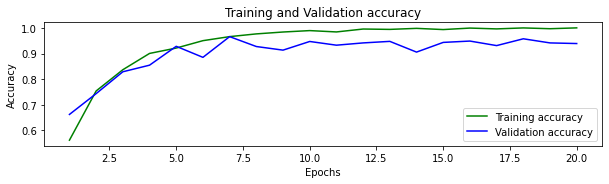

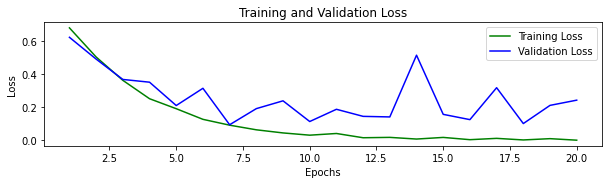

In [17]:
#Plotting the accuracy versus epochs
acc_versus_epochs(hist_bin)

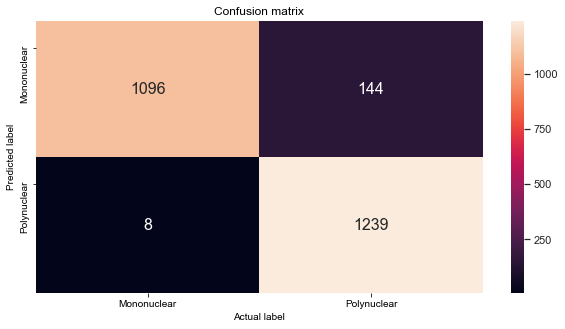

In [18]:
#Plotting the confusion matrix
y_true = conf_mat_bin[0];
y_pred = conf_mat_bin[1];
plot_confusion_matrix_bin(confusion_matrix(y_true,y_pred))

In [19]:
from sklearn.metrics import recall_score
print("Accuracy for each class : " , recall_score(y_true, y_pred, average=None))

from sklearn.metrics import precision_score
print("Precision score " , precision_score(y_true, y_pred, average=None))

Accuracy for each class :  [0.88387097 0.9935846 ]
Precision score  [0.99275362 0.89587852]


In [20]:
keras.backend.clear_session()

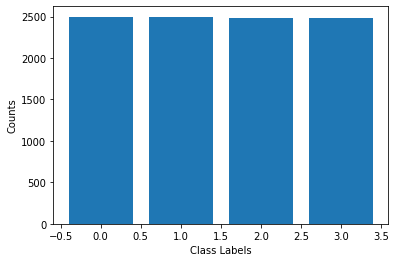

In [13]:
#To show the count of training data in each label
import pandas as pd
import matplotlib.pyplot as plt


df = pd.DataFrame()
df["labels"] = y_train_multi
counts = df['labels'].value_counts()
fig, ax = plt.subplots()
plt.bar(counts.index, counts.values)
ax.set_xlabel('Class Labels')
ax.set_ylabel('Counts')
plt.show()

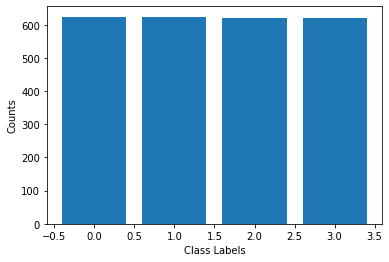

In [14]:
#To show the count of test data in each label

df = pd.DataFrame()
df["labels"] = y_test_multi
counts = df['labels'].value_counts()
fig, ax = plt.subplots()
plt.bar(counts.index, counts.values)
ax.set_xlabel('Class Labels')
ax.set_ylabel('Counts')
plt.show()

In [18]:
print("Shape of train data : ",X_train_multi.shape)
print("Shape of test data : ",X_test_multi.shape)
print("Shape of train labels after one hot encoding : ",y_trainHot_multi.shape)
print("Shape of test labels after one hot encoding : ",y_testHot_multi.shape)

Shape of train data :  (9957, 80, 80, 3)
Shape of test data :  (2487, 80, 80, 3)
Shape of train labels after one hot encoding :  (9957, 5)
Shape of test labels after one hot encoding :  (2487, 5)


In [20]:
#The main CNN architecture
import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, MaxPool2D
from sklearn.metrics import classification_report, confusion_matrix

#The binary labels for our CNN model in the form of a dictionary
multi_labels = {0:'Neutrophil',1:'Eosinophil',2:'Monocyte',3:'Lymphocyte'}

def CNN(imgs,img_labels,test_imgs,test_labels,stride):
    
    #Number of classes (4)
    num_classes = len(img_labels[0])
    
    epochs = 20
    
    #Size of image
    img_rows,img_cols=imgs.shape[1],imgs.shape[2]
    input_shape = (img_rows, img_cols, 3)
    
    #Creating the model
    model = Sequential()
    
    #First convolution layer
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,
                     strides=stride))
    
    #First maxpooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #Second convolution layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    
    #Second maxpooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #Dropout layer
    model.add(Dropout(0.2))
    
    #Third convolution layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    
    #Third maxpooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #Convert the matrix to a fully connected layer
    model.add(Flatten())
    
    #Dense function to convert FCL to 128 values
    model.add(Dense(128, activation='relu'))
    
    #Dropout layer
    model.add(Dropout(0.5))
    
    #Final dense layer on which softmax function is performed
    model.add(Dense(num_classes, activation='sigmoid'))
    
    #Model parameters
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    #Evaluate the model on the test data before training your model
    score = model.evaluate(test_imgs,test_labels, verbose=1)
    
    print('\nKeras CNN binary accuracy:', score[1],'\n')
    
    #The model details
    history = model.fit(imgs,img_labels,
                        shuffle = True, 
                        epochs = epochs, 
                        validation_data = (test_imgs, test_labels))
    
    #Evaluate the model on the test data after training your model
    score = model.evaluate(test_imgs,test_labels, verbose=1)
    print('\nKeras CNN binary accuracy:', score[1],'\n')
    
    #Predict the labels from test data
    y_pred = model.predict(test_imgs)
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(test_labels,axis=1)
    
    #Correct labels
    for i in range(len(Y_true)):
        if(Y_pred_classes[i] == Y_true[i]):
            print("The predicted class is : " , Y_pred_classes[i])
            print("The real class is : " , Y_true[i])
            break
            
    #The confusion matrix made from the real Y values and the predicted Y values
    confusion_mtx = [Y_true, Y_pred_classes]
    
    #Summary of the model
    model.summary()
    
    return model,confusion_mtx,history
   
model_multi,conf_mat_multi,hist_multi = CNN(X_train_multi,y_trainHot_multi,X_test_multi,y_testHot_multi,1);

78/78 [==============================] - 2s 20ms/step - loss: 0.6708 - accuracy: 0.0024

Keras CNN binary accuracy: 0.0024125452619045973 

Epoch 1/20
312/312 [==============================] - 31s 98ms/step - loss: 0.4676 - accuracy: 0.2594 - val_loss: 0.4616 - val_accuracy: 0.2493
Epoch 2/20
312/312 [==============================] - 32s 103ms/step - loss: 0.4576 - accuracy: 0.2535 - val_loss: 0.4513 - val_accuracy: 0.2493
Epoch 3/20
312/312 [==============================] - 31s 98ms/step - loss: 0.4552 - accuracy: 0.2552 - val_loss: 0.4549 - val_accuracy: 0.2384
Epoch 4/20
312/312 [==============================] - 30s 97ms/step - loss: 0.4539 - accuracy: 0.2573 - val_loss: 0.4527 - val_accuracy: 0.2509
Epoch 5/20
312/312 [==============================] - 31s 101ms/step - loss: 0.4089 - accuracy: 0.4110 - val_loss: 0.3303 - val_accuracy: 0.6035
Epoch 6/20
312/312 [==============================] - 31s 100ms/step - loss: 0.3315 - accuracy: 0.5601 - val_loss: 0.3269 - val_accuracy: 

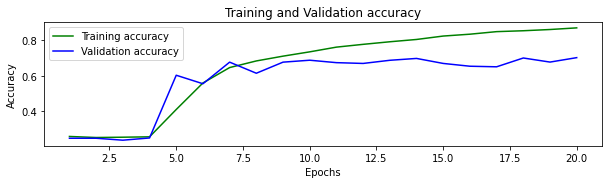

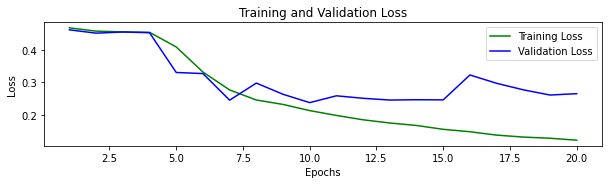

In [25]:
#Plotting the accuracy versus epochs
acc_versus_epochs(hist_multi)

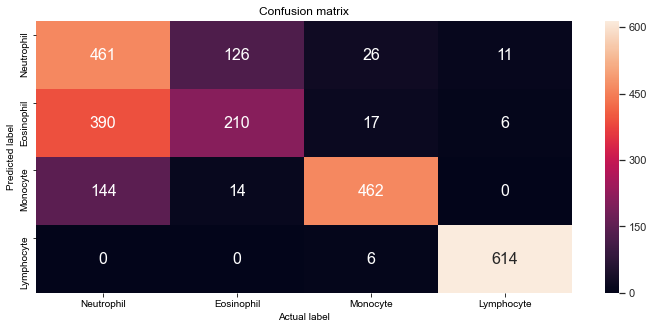

In [26]:
#Plotting the confusion matrix
y_true = conf_mat_multi[0];
y_pred = conf_mat_multi[1];
plot_confusion_matrix_multi(confusion_matrix(y_true,y_pred))

In [30]:
from sklearn.metrics import recall_score, precision_score
print("Accuracy for each class : " , recall_score(y_true, y_pred, average=None))
print("Precision score " , precision_score(y_true, y_pred, average=None))

Accuracy for each class :  [0.73878205 0.33707865 0.74516129 0.99032258]
Precision score  [0.46331658 0.6        0.90410959 0.97305864]
